# Table of Contents

1. [Basic Usage](./basic%20usage.ipynb)
2. Inserting Protocols into an existing schedule
3. [Using Breakpoints](./using%20breakpoints.ipynb)

In [1]:
import roboflo as rf
import numpy as np
import matplotlib.pyplot as plt

# Quick initialization of our system

Please refer to the [basic usage](./basic%20usage.ipynb) example if this section doesn't make sense

In [4]:
hotplate = rf.Worker(
    name='hotplate',
    capacity=25
)

spincoater = rf.Worker(
    name='spincoater',
    capacity=1
)

storage = rf.Worker(
    name='storage',
    capacity=45,
)

characterization = rf.Worker(
    name='characterization line',
    capacity=1
)

arm = rf.Worker(
    name='arm',
    capacity=1
)

In [5]:
transitions = [
    rf.Transition(
        duration=28,
        source=storage,
        destination=spincoater,
        workers=[arm]
    ),
    rf.Transition(
        duration=20,
        source=spincoater,
        destination=hotplate,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=hotplate,
        destination=storage,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=storage,
        destination=characterization,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=characterization,
        destination=storage,
        workers=[arm]
    ),
    rf.Transition(
        duration=30,
        source=characterization,
        destination=spincoater,
        workers=[arm]
    ),
    rf.Transition(
        duration=30,
        source=spincoater,
        destination=characterization,
        workers=[arm]
    )
]

In [7]:
system = rf.System(
    workers=[storage, spincoater, hotplate, arm, characterization],
    transitions=transitions,
    starting_worker=storage,
    ending_worker=storage,
)

# Inserting Protocols on the fly

In [8]:
def add_generic_protocol(min_start=0):
    """
    Makes a protocol with some random durations to simulate changing parameters as the experiment progresses
    """
    system.generate_protocol(
        worklist = [
            rf.Task(
                name='spincoat',
                workers=[spincoater],
                duration=40 + np.random.random()*20,
                immediate=True,
            ),
            rf.Task(
                name='anneal',
                workers=[hotplate],
                duration=np.random.choice([900, 1200, 1800]),
                immediate=True
            ),
            rf.Task(
                name='rest',
                workers=[storage],
                duration=180,
                immediate=True
            ),
            rf.Task(
                name='characterize',
                workers=[characterization],
                duration=300,
                immediate=False
            ),
            rf.Task(
                name='spincoat',
                workers=[spincoater],
                duration = 60 + np.random.random()*30,
                immediate=False
            ),
            rf.Task(
                name='characterize',
                workers=[characterization],
                duration=300,
                immediate=False
            ),        
        ],
        min_start=min_start
    )

Lets start with six protocols in the queue

Solving final schedule
	solution status: OPTIMAL


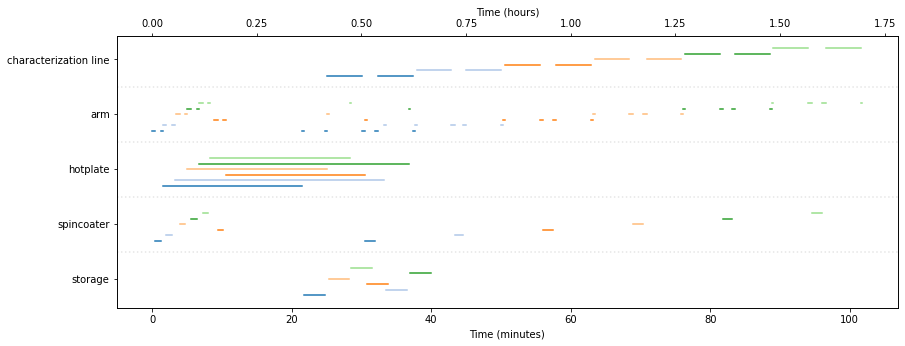

In [9]:
for i in range(6):
    add_generic_protocol()

system.scheduler.solve(
    solve_time=10,
)
system.scheduler.plot_solution()

Now, we will pretend that, once all but the last five original protocols have completed, we will add a single new protocol for each earlier protocol that completes. We will also give ourselves some buffer time to plan and start the new protocol. 

This is a plausible scenario for closed-loop experimentation, where we might begin with a batch of experiments to initialize the search space, then follow up individual experiments in cycles of say Bayesian Optimization

In [10]:
REMAINING_PROTOCOLS = 5
BUFFER_TIME = 10
BATCH_SIZE = 1

def add_and_solve():
    start_time = system.scheduler.get_tasklist_by_worker()[spincoater][-REMAINING_PROTOCOLS].end + BUFFER_TIME #characterization is the final worker, we look at the end time of that task and add some buffer time
    for i in range(BATCH_SIZE):
        add_generic_protocol(min_start = start_time)
        
    system.scheduler.solve(solve_time=10)
    return start_time

Simulating 10 rounds of additional samples inserted into the schedule. The vertical line shows the most recent start time (ie the earliest allowed start time for tasks from the latest protocol). This is to simulate scheduling tasks at that point in time -- we cant run things in the past :)

Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL


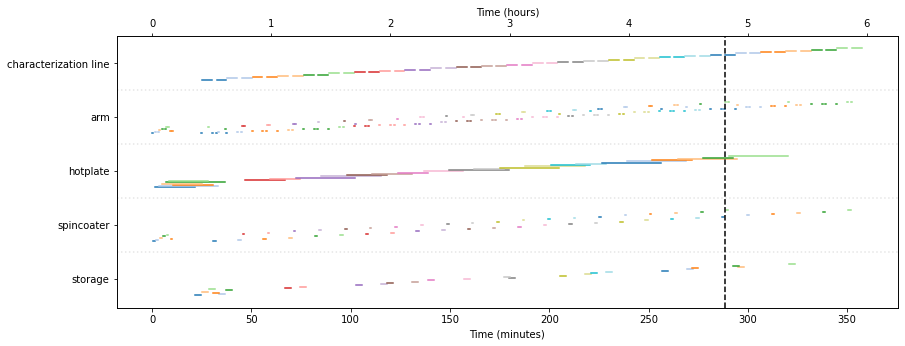

In [12]:
for i in range(10):
    start_time = add_and_solve()
system.scheduler.plot_solution()
plt.axvline(start_time/60, linestyle='--', color='k')
plt.show()

## Insert tasks with flexible solve

In the previous example, no solved start time is allowed to change on subsequent schedule solutions. Even if a Task is scheduled to occur hours later than the current time, it will not be rescheduled.

We can allow for future (yet already scheduled) Tasks to be rescheduled by running `system.scheduler.flex(cutoff_time)`, which basically forgets the starting times for anything beyond the cutoff. This can allow us to further optimize a schedule that is still in progress when we insert new protocols. 

In [17]:
REMAINING_PROTOCOLS = 5
BUFFER_TIME = 10
BATCH_SIZE = 1

def add_and_solve_flexible():
    start_time = system.scheduler.get_tasklist_by_worker()[spincoater][-REMAINING_PROTOCOLS].end + BUFFER_TIME #characterization is the final worker, we look at the end time of that task and add some buffer time
    system.scheduler.flex(cutoff_time=start_time) #NOTE THIS LINE HAS BEEN ADDED TO FLEX THE SCHEDULE!
    for i in range(BATCH_SIZE):
        add_generic_protocol(min_start = start_time)

    system.scheduler.solve(solve_time=10)
    return start_time

In [18]:
system = rf.System(
    workers=[storage, spincoater, hotplate, arm, characterization],
    transitions=transitions,
    starting_worker=storage,
    ending_worker=storage,
)

Solving final schedule
	solution status: OPTIMAL


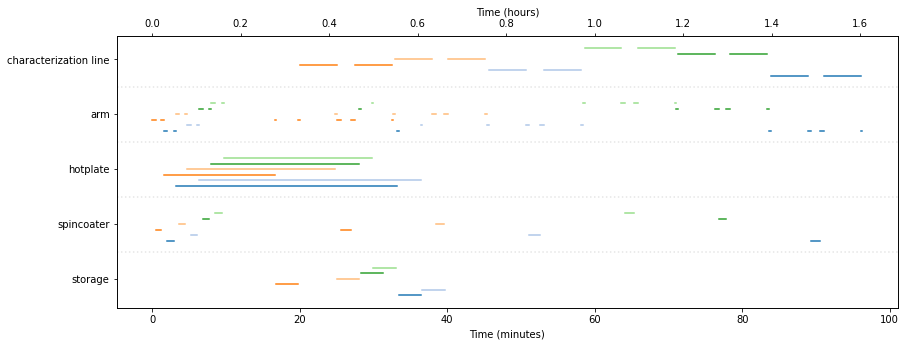

In [19]:
for i in range(6):
    add_generic_protocol()

system.scheduler.solve(
    solve_time=10,
)
system.scheduler.plot_solution()

Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL


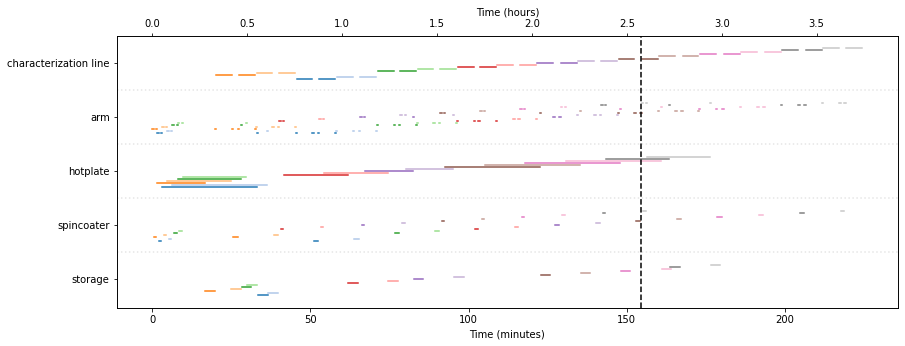

In [20]:
for i in range(10):
    start_time = add_and_solve_flexible()
system.scheduler.plot_solution()
plt.axvline(start_time/60, linestyle='--', color='k')
plt.show()